In [24]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [25]:
# 중복된 피처명을 수정하는 함수
def get_new_feature_name_df(old_feature_name_df):
    # 중복된 피처명을 'dup_cnt' 컬럼으로 가지는 데이터프레임 생성
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    
    # 기존 피처명 데이터프레임과 중복 피처명 데이터프레임을 병합
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    
    # 중복된 피처명에 대해 '_dup_cnt'를 추가하여 새로운 피처명을 생성
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
        lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    
    # 'index' 컬럼 제거하여 새로운 피처명 데이터프레임 반환
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    
    return new_feature_name_df

# 휴먼 액티비티 인식 데이터셋 로드 및 전처리 함수
def get_human_dataset():
    # 피처명을 포함한 데이터 파일 로드
    feature_name_df = pd.read_csv('../dataset/UCI_HAR_Dataset/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 함수를 호출하여 새로운 피처명 데이터프레임 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # 새로운 피처명을 리스트로 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 데이터와 테스트 데이터 로드. 컬럼명에 피처명 적용
    X_train = pd.read_csv('../dataset/UCI_HAR_Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('../dataset/UCI_HAR_Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터 로드. 컬럼명을 'action'으로 부여
    y_train = pd.read_csv('../dataset/UCI_HAR_Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('../dataset/UCI_HAR_Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드한 학습 데이터와 테스트 데이터를 모두 반환
    return X_train, X_test, y_train, y_test

In [26]:
# get_human_dataset()를 사용해 Train/Test data load
X_train, X_test, y_train, y_test = get_human_dataset()

# 학습 피처 데이터의 정보 출력
print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


# CNN Feature

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

## Split_sequence
split_sequences(sequences, n_steps) 이용시, csv를 딥러닝 이용 가능
+ error_bad_lines=False >> 에러 스킵가능

In [32]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)



In [33]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]


# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

(7328, 25, 561) (7328,)
(2923, 25, 561) (2923,)


In [35]:
# 모델 구조 정의

# 입력 데이터의 크기를 기반으로 입력 형태를 설정합니다.
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 128)               1032320   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1034886 (3.95 MB)
Trainable params: 1034886 (3.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# 모델 구조 정의

# 입력 데이터의 크기를 기반으로 입력 형태를 설정합니다.
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential() # Sequential 모델 생성

# 1D-CNN 추가
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))

# 또 다른 1D-CNN 추가
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5)) # 드롭아웃 레이어를 추가(드롭아웃 비율 0.5)
model.add(MaxPooling1D(pool_size=2)) # 맥스 풀링 레이어를 추가 (풀링 크기 2)
model.add(Flatten()) # 1D-CNN 출력을 Flatten
model.add(Dense(100, activation='relu')) # 완전 연결(Dense) 레이어를 추가합니다. (뉴런 수 100, 활성화 함수 'relu')
model.add(Dense(n_outputs, activation='softmax')) # 출력 레이어 추가 (클래스 수에 해당하는 뉴런 수, 활성화 함수 'softmax')
plot_model(model, show_shapes=True, show_layer_names=True) # 모델 구조를 시각화 (레이어의 형태와 이름을 표시)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
batch_size = 64 # 미니배치 크기 설정
validation_split = 0.2 # 검증 데이터 비율 설정 (20%는 검증 데이터로 사용)

In [43]:
# 모델 학습 설정 및 실행
train_epochs = 20

# Model train
history = model.fit(
    trainX,                 # 학습 데이터 (입력)
    trainy,                 # 학습 데이터 (타겟)
    epochs=train_epochs,    # 학습 에포크 수
    batch_size=batch_size,  # 배치 크기
    verbose=True,           # 학습 과정 로그 출력 여부 (True로 설정하면 학습 진행 상황이 출력됨)
    validation_split=validation_split,  # 검증 데이터를 위한 분할 비율
    shuffle=True            # 데이터를 섞을지 여부 (True로 설정하면 에포크마다 데이터가 섞임)
)

Epoch 1/20
92/92 [==============================] - 3s 24ms/step - loss: 0.5160 - accuracy: 0.7883 - val_loss: 0.4795 - val_accuracy: 0.8926
Epoch 2/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1501 - accuracy: 0.9434 - val_loss: 0.4280 - val_accuracy: 0.9001
Epoch 3/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1080 - accuracy: 0.9548 - val_loss: 0.3526 - val_accuracy: 0.9157
Epoch 4/20
92/92 [==============================] - 2s 23ms/step - loss: 0.0954 - accuracy: 0.9573 - val_loss: 0.3422 - val_accuracy: 0.8926
Epoch 5/20
92/92 [==============================] - 2s 24ms/step - loss: 0.0953 - accuracy: 0.9587 - val_loss: 0.4037 - val_accuracy: 0.9041
Epoch 6/20
92/92 [==============================] - 2s 21ms/step - loss: 0.0819 - accuracy: 0.9589 - val_loss: 0.4253 - val_accuracy: 0.9109
Epoch 7/20
92/92 [==============================] - 2s 25ms/step - loss: 0.0851 - accuracy: 0.9617 - val_loss: 0.2575 - val_accuracy: 0.8987
Epoch 8/20
92

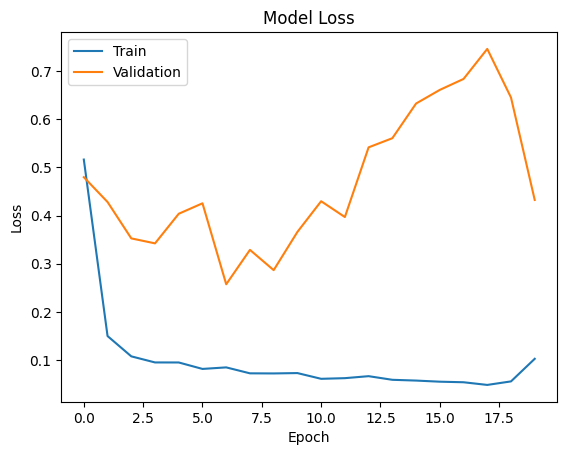

In [44]:
# 학습 손실 시각화

# 학습 과정에서 기록한 훈련 손실과 검증 손실 데이터를 시각화합니다.
plt.plot(history.history['loss'], label='Training Loss')        # 훈련 손실
plt.plot(history.history['val_loss'], label='Validation Loss')  # 검증 손실

# 그래프 제목과 레이블 설정
plt.title('Model Loss')  # 그래프 제목
plt.xlabel('Epoch')      # x축 레이블 (에포크)
plt.ylabel('Loss')       # y축 레이블 (손실)

# 범례(legend) 표시 (훈련 손실과 검증 손실에 대한 범례)
plt.legend(['Train', 'Validation'], loc='upper left')

# 그래프를 표시합니다.
plt.show()

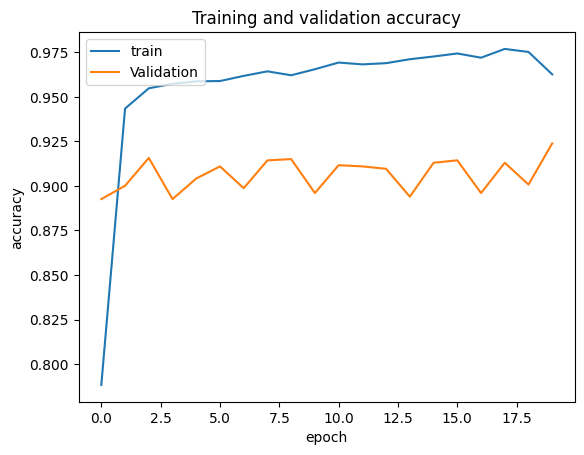

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')